This script performs data cleaning and preparation on a LendingClub dataset to make it ready for machine learning modeling. It imports the dataset from an external source and a data dictionary that provides information on each variable.

Next, the script drops columns that are not needed for the analysis, such as URLs, descriptions, and IDs. It also removes rows with loan statuses other than "Charged Off" or "Fully Paid" since those are the only statuses relevant for this analysis.

The script then calculates new metrics such as the fraction of the loan recovered and the days since the last payment. It also handles joint loan applications by combining the income and debt-to-income ratio of joint applicants.

Finally, the cleaned and prepared dataset is saved as a joblib file for further analysis. By performing these cleaning and preparation steps, the dataset is now ready for machine learning modeling and can be used to predict loan application approval and assess risk.

The DataFrame contains 2,260,701 observations and each observation has 151 variables.

In [8]:
import pandas as pd
data_raw = pd.read_csv(
  "./accepted_2007_to_2018Q4.csv",
  low_memory=False,
)

data_raw.shape

(2260701, 151)

In [9]:
data_raw.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


This code reads in the LCDataDictionary.xlsx file, which is a data dictionary that provides descriptions for each of the variables in the LendingClub loan dataset.
This is a helpful way to understand what each variable represents in the dataset.

In [10]:
variable_definitions = pd.read_excel("https://resources.lendingclub.com/LCDataDictionary.xlsx")

# Drop blank rows, strip white space, set the "LoanStatNew" column as the index, and converting the "Description" column to a Python dictionary.
variable_definitions.dropna(axis="index", inplace=True)
variable_definitions = variable_definitions.applymap(lambda x: x.strip())
variable_definitions.set_index("LoanStatNew", inplace=True)
dictionary = variable_definitions["Description"].to_dict()
# Rename "verified_status_joint" to "verification_status_joint".
dictionary["verification_status_joint"] = dictionary.pop("verified_status_joint")

# Print out each column name in the data_raw and its corresponding description from the data dictionary
for col in data_raw.columns:
  print(f"•{col}: {dictionary[col]}")

•id: A unique LC assigned ID for the loan listing.
•member_id: A unique LC assigned Id for the borrower member.
•loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
•funded_amnt: The total amount committed to that loan at that point in time.
•funded_amnt_inv: The total amount committed by investors for that loan at that point in time.
•term: The number of payments on the loan. Values are in months and can be either 36 or 60.
•int_rate: Interest Rate on the loan
•installment: The monthly payment owed by the borrower if the loan originates.
•grade: LC assigned loan grade
•sub_grade: LC assigned loan subgrade
•emp_title: The job title supplied by the Borrower when applying for the loan.*
•emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
•home_ownership: The home owner

Here are the descriptions of each of the columns used to calculate the model output:

term: The number of payments on the loan. Values are in months and can be either 36 or 60.
installment: The monthly payment owed by the borrower if the loan is funded.
total_rec_prncp: The total principal amount of the loan that has been paid off by the borrower.
total_rec_int: The total interest amount that has been paid by the borrower.
total_rec_late_fee: The total late fee amount that has been paid by the borrower.
recoveries: The post charge off gross recovery amount.
collection_recovery_fee: The post charge off collection fee.

Here is the formula we can use to calculate the final model output:

Expected Return = term x installment
Amount Received = total_rec_prncp + total_rec_int + total_rec_late_fee + recoveries - collection_recovery_fee
Fraction of Expected Return Recovered = Amount Received / Expected Return

In [11]:
output_columns = ["term", "installment", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee"]

Some columns contain irrelevant demographic data or data that was not created until after a loan was accepted, and thus those columns need to be removed. The column "emp_title" (the applicant's job title) is potentially relevant in the context of a loan, but it has too many unique values to be useful. We can drop this column for now.

In [12]:
data_raw["emp_title"].nunique()

512694

In [13]:
dropped_columns = ["id", "member_id", "funded_amnt", "funded_amnt_inv", "int_rate", "grade", "sub_grade", "emp_title", "pymnt_plan", "url", "desc", "title", "zip_code", "addr_state", "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "last_pymnt_d", "last_pymnt_amnt", "next_pymnt_d", "last_credit_pull_d", "last_fico_range_high", "last_fico_range_low", "policy_code", "hardship_flag", "hardship_type", "hardship_reason", "hardship_status", "deferral_term", "hardship_amount", "hardship_start_date", "hardship_end_date", "payment_plan_start_date", "hardship_length", "hardship_dpd", "hardship_loan_status", "orig_projected_additional_accrued_interest", "hardship_payoff_balance_amount", "hardship_last_payment_amount", "disbursement_method", "debt_settlement_flag", "debt_settlement_flag_date", "settlement_status", "settlement_date", "settlement_amount", "settlement_percentage", "settlement_term"]
data = data_raw.drop(columns=dropped_columns)

There is only 1 record with value educational in purpose column. This cleaning step can help improve the quality of subsequent analysis and modeling by reducing the number of categories in the "purpose" column and grouping similar loan purposes together.

In [14]:
data["purpose"] = data["purpose"].replace("educational", "other")

Group the data by the "loan_status" column, and then counts the number of occurrences of each unique value in the "loan_status" column

In [15]:
data.groupby("loan_status")["loan_status"].count()

loan_status
Charged Off                                             268559
Current                                                 878317
Default                                                     40
Does not meet the credit policy. Status:Charged Off        761
Does not meet the credit policy. Status:Fully Paid        1988
Fully Paid                                             1076751
In Grace Period                                           8436
Late (16-30 days)                                         4349
Late (31-120 days)                                       21467
Name: loan_status, dtype: int64

For practical purposes, we decide to only consider loans with statuses containing "Fully Paid" or "Charged Off" as these indicate the loan is no longer active. The "credit policy" columns were also merged with their matching status.

In [16]:
credit_policy_related = "Does not meet the credit policy. Status:"
len_credit_policy_related = len(credit_policy_related)

def remove_credit_policy_related(status):
    if credit_policy_related in str(status):
        return status[len_credit_policy_related:]
    else:
        return status

data["loan_status"] = data["loan_status"].apply(remove_credit_policy_related)

rows_to_drop = data[(data["loan_status"] != "Charged Off") & (data["loan_status"] != "Fully Paid")].index
data.drop(index=rows_to_drop, inplace=True)

data.groupby("loan_status")["loan_status"].count()

loan_status
Charged Off     269320
Fully Paid     1078739
Name: loan_status, dtype: int64

Fix a data from purpose column.

<Axes: xlabel='loan_status', ylabel='count'>

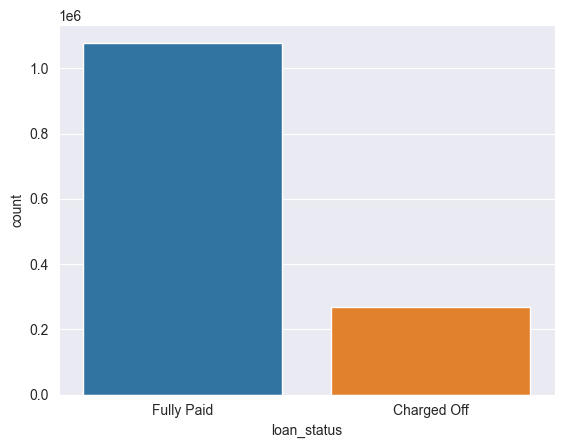

In [17]:
import seaborn as sns
sns.countplot(x='loan_status', data = data)

The plot shows a histogram of the loan amount distribution in the dataset. The x-axis represents the loan amount and the y-axis represents the count (or frequency) of loans in the corresponding loan amount bin. It appears that the majority of loans fall within the range of 0 to 40,000, with a peak around 10,000.

<Axes: xlabel='loan_amnt', ylabel='Count'>

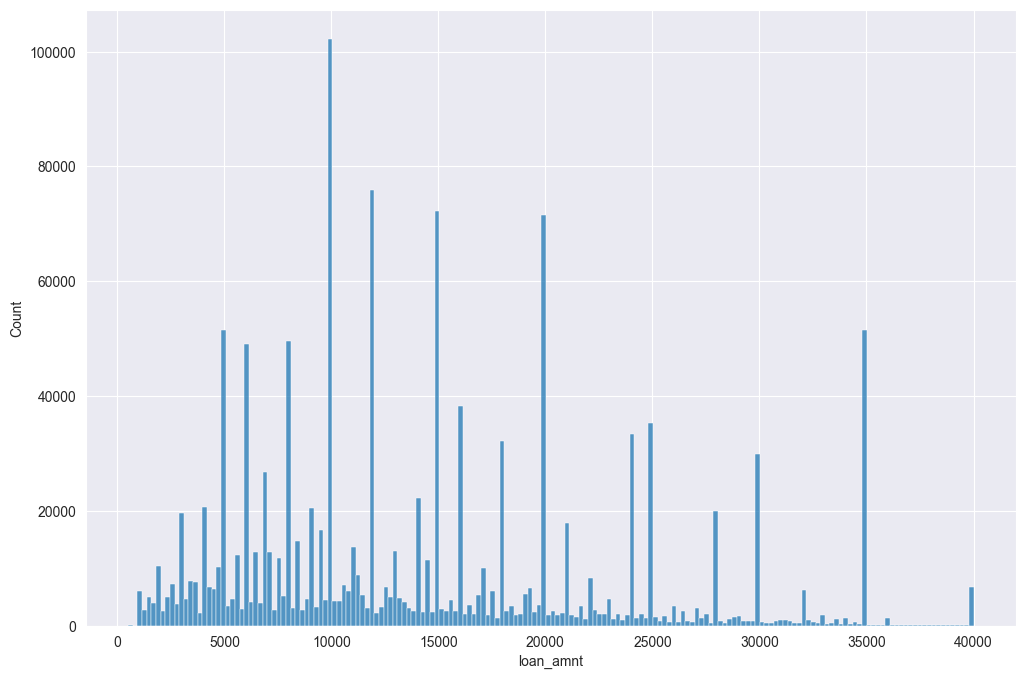

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (12,8))
sns.histplot(x='loan_amnt', data = data)

In [19]:
data[output_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1348059 entries, 0 to 2260697
Data columns (total 7 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   term                     1348059 non-null  object 
 1   installment              1348059 non-null  float64
 2   total_rec_prncp          1348059 non-null  float64
 3   total_rec_int            1348059 non-null  float64
 4   total_rec_late_fee       1348059 non-null  float64
 5   recoveries               1348059 non-null  float64
 6   collection_recovery_fee  1348059 non-null  float64
dtypes: float64(6), object(1)
memory usage: 82.3+ MB


In [20]:
data.groupby("term")["term"].count()

term
 36 months    1023181
 60 months     324878
Name: term, dtype: int64

The following steps can help improve the quality of subsequent analysis and modeling by creating a numerical version of the "term" column that can be used for further calculation.

In [21]:
# Strip leading/trailing whitespace from the term column
data["term"] = data["term"].map(lambda term_str: term_str.strip())

# Extract the numerical value from the term column and store it in a new column called term_num
extract_num = lambda term_str: float(term_str[:2])
data["term_num"] = data["term"].map(extract_num)

# Remove the original term column from the list of output columns and add the new term_num column
output_columns.remove("term")
output_columns.append("term_num")

Here is the formula we can use to calculate the final model output:
Expected Return = term x installment
Amount Received = total_rec_prncp + total_rec_int + total_rec_late_fee + recoveries - collection_recovery_fee
Fraction of Expected Return Recovered = Amount Received / Expected Return

In [22]:
received = data[["total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries"]].sum(axis=1) - data["collection_recovery_fee"]
expected = data["installment"] * data["term_num"]
data["recovered_percentage"] = received / expected

data.groupby("loan_status")["recovered_percentage"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,269320.0,0.400162,0.219020,0.000000,0.224463,0.367554,0.550924,2.410680
Fully Paid,1078739.0,0.932705,0.100455,0.506053,0.897912,0.960100,0.997612,60.932353


In [23]:
import numpy as np

# set a maximum value of 1 for the recovered_percentage variable
data["recovered_percentage"] = np.where(
  (data["loan_status"] == "Fully Paid") | (data["recovered_percentage"] > 1.0),
  1.0,
  data["recovered_percentage"],
)

# group the data by loan_status and describe the recovered_percentage variable
data.groupby("loan_status")["recovered_percentage"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,269320.0,0.400152,0.218971,0.0,0.224463,0.367554,0.550924,1.0
Fully Paid,1078739.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.0


This code generates a kernel density plot to visualize the distribution of the "recovered_percentage" variable for loans that were charged off.

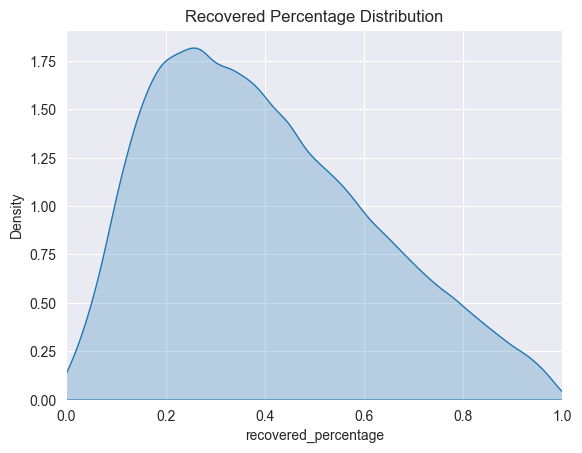

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.kdeplot(
  data=data["recovered_percentage"][data["loan_status"] == "Charged Off"],
  label="Charged Off",
  fill=True,
)
plt.axis(xmin=0, xmax=1)
plt.title('Recovered Percentage Distribution')
plt.show()

Checking the null counts of each variable is an important step in data cleaning. By identifying which variables have missing data, we can decide how to handle these missing values.

In [25]:
# The verbose parameter is set to True to show the counts of non-null values.
data.drop(columns=output_columns, inplace=True)
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1348059 entries, 0 to 2260697
Data columns (total 97 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   loan_amnt                            1348059 non-null  float64
 1   term                                 1348059 non-null  object 
 2   emp_length                           1269514 non-null  object 
 3   home_ownership                       1348059 non-null  object 
 4   annual_inc                           1348055 non-null  float64
 5   verification_status                  1348059 non-null  object 
 6   issue_d                              1348059 non-null  object 
 7   loan_status                          1348059 non-null  object 
 8   purpose                              1348059 non-null  object 
 9   dti                                  1347685 non-null  float64
 10  delinq_2yrs                          1348030 non-null  float64
 11  ear

The columns with a high number of null values can be categorized into three groups:
1. derogatory/delinquency metrics, where null values indicate no such marks;
2. metrics applicable only to joint applications, where null values indicate a single application;
3. a group of 14 credit history-related columns with only 537,000 entries, which raises questions about their novelty.

Additionally, I will include "mths_since_recent_inq" in the first category since its non-null count falls below the threshold of complete data at around 1,277,783, and null values here may indicate no recent inquiries.

In [26]:
# related to negative marks on a borrower's credit report, such as delinquencies, defaults, or bankruptcies.
negative_mark_columns = ["mths_since_last_delinq", "mths_since_last_record", "mths_since_last_major_derog", "mths_since_recent_bc_dlq", "mths_since_recent_inq", "mths_since_recent_revol_delinq", "mths_since_recent_revol_delinq", "sec_app_mths_since_last_major_derog"]
# includes the names of columns in the LendingClub dataset that are related to joint applications for loans.
joint_columns = ["annual_inc_joint", "dti_joint", "verification_status_joint", "revol_bal_joint", "sec_app_fico_range_low", "sec_app_fico_range_high", "sec_app_earliest_cr_line", "sec_app_inq_last_6mths", "sec_app_mort_acc", "sec_app_open_acc", "sec_app_revol_util", "sec_app_open_act_il", "sec_app_num_rev_accts", "sec_app_chargeoff_within_12_mths", "sec_app_collections_12_mths_ex_med", "sec_app_mths_since_last_major_derog"]
# includes the names of columns in the LendingClub dataset that may be difficult to interpret or analyze
confusing_columns = ["open_acc_6m", "open_act_il", "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il", "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc", "all_util", "inq_fi", "total_cu_tl", "inq_last_12m"]

Analyse the confusing_columns first.

In [27]:
# Convert "issue_d" column to datetime format
data["issue_d"] = data["issue_d"].astype("datetime64[ns]")

# Check the date range of confusing columns by selecting the confusing columns and the "issue_d" column,
# removing rows with null values, and then computing the count, min and max values for "issue_d"
data[confusing_columns + ["issue_d"]].dropna(axis="index")["issue_d"].agg(
  ["count", "min", "max"]
)

/var/folders/d5/hpc31dsx59l4rfyrs6m6yvp00000gn/T/ipykernel_88860/2335218645.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["issue_d"] = data["issue_d"].astype("datetime64[ns]")


count                 464325
min      2015-12-01 00:00:00
max      2018-12-01 00:00:00
Name: issue_d, dtype: object

It's interesting to note that confusing_columns were only introduced in December 2015 and are sparsely populated even after that point. They may not be useful for the current analysis.

In [28]:
new_metric_columns = confusing_columns

To process the derogatory/delinquency metrics, I will follow Michael Wurm's suggestion and obtain the inverse of all the “months since recent/last” fields. This conversion will transform each field into a proxy for the frequency of the event, while allowing me to assign a 0 value to all the null fields (when an event has never occurred). For the “months since oldest” fields, I will set the null values to 0 and leave the remaining fields unchanged.

In [29]:
# Identify columns with "months since" and "months since recent" in their name
months_since_last_columns = [
    col_name for col_name in data.columns if "mths_since" in col_name or "mo_sin_rcnt" in col_name
]

# For "months since" columns, if the value is 0, set it to 1 to avoid dividing by zero. If the value is already a number of months, take the inverse.
for col_name in months_since_last_columns:
    data[col_name] = [
        0.0 if pd.isna(months) else 1 / 1 if months == 0 else 1 / months
        for months in data[col_name]
    ]

# Rename inverse columns
rename_mapper = {}
for col_name in months_since_last_columns:
    rename_mapper[col_name] = col_name.replace("mths_since", "inv_mths_since").replace(
        "mo_sin_rcnt", "inv_mo_sin_rcnt"
    )
data.rename(columns=rename_mapper, inplace=True)

# Identify columns with "months since oldest" in their name
months_since_oldest_columns = [
    col_name for col_name in data.columns if "mo_sin_old" in col_name
]

# Replace null values in "months since oldest" columns with 0
data.loc[:, months_since_oldest_columns].fillna(0, inplace=True)

def replace_list_value(l, old_value, new_value):
  i = l.index(old_value)
  l.pop(i)
  l.insert(i, new_value)

# Replace columns in new_metric_columns with their inverse values
replace_list_value(new_metric_columns, "mths_since_rcnt_il", "inv_mths_since_rcnt_il")
replace_list_value(
    joint_columns,
    "sec_app_mths_since_last_major_derog",
    "sec_app_inv_mths_since_last_major_derog",
)

Take a look at joint loans, it seems there are newer metrics for joint applications as well.

In [30]:
joint_loans = data[:][data["application_type"] == "Joint App"]
joint_loans[joint_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 25800 entries, 2 to 2260663
Data columns (total 16 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   annual_inc_joint                         25800 non-null  float64
 1   dti_joint                                25797 non-null  float64
 2   verification_status_joint                25595 non-null  object 
 3   revol_bal_joint                          18629 non-null  float64
 4   sec_app_fico_range_low                   18630 non-null  float64
 5   sec_app_fico_range_high                  18630 non-null  float64
 6   sec_app_earliest_cr_line                 18630 non-null  object 
 7   sec_app_inq_last_6mths                   18630 non-null  float64
 8   sec_app_mort_acc                         18630 non-null  float64
 9   sec_app_open_acc                         18630 non-null  float64
 10  sec_app_revol_util                       18302 no

In [31]:
# List of columns with new metrics that only apply to joint applications
joint_new_metric_columns = ["revol_bal_joint", "sec_app_fico_range_low", "sec_app_fico_range_high", "sec_app_earliest_cr_line", "sec_app_inq_last_6mths", "sec_app_mort_acc", "sec_app_open_acc", "sec_app_revol_util", "sec_app_open_act_il", "sec_app_num_rev_accts", "sec_app_chargeoff_within_12_mths", "sec_app_collections_12_mths_ex_med", "sec_app_inv_mths_since_last_major_derog"]

# Check date range of joint loan data with new metrics
joint_loans[joint_new_metric_columns + ["issue_d"]].dropna(axis="index")["issue_d"].agg(
["count", "min", "max"]
)

count                  18301
min      2017-03-01 00:00:00
max      2018-12-01 00:00:00
Name: issue_d, dtype: object

In [32]:
joint_loans["issue_d"].agg(["count", "min", "max"])

count                  25800
min      2015-10-01 00:00:00
max      2018-12-01 00:00:00
Name: issue_d, dtype: object

Based on output, it can be determined joint_new_metric_columns are newly added features from 2017-03-01.

Replace the values in certain columns of the joint application dataframe with the corresponding values from the individual application dataframe, but only for non-joint applications.

In [33]:
# iterating through pairs of corresponding column names from the joint and individual dataframes
for joint_col, indiv_col in zip(
        ["annual_inc_joint", "dti_joint", "verification_status_joint"],
        ["annual_inc", "dti", "verification_status"],
):
    # using a list comprehension to replace the joint application values with the individual application values when the application type is not "Joint App"
  data[joint_col] = [
    joint_val if app_type == "Joint App" else indiv_val
    for app_type, joint_val, indiv_val in zip(
      data["application_type"], data[joint_col], data[indiv_col]
    )
  ]

data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1348059 entries, 0 to 2260697
Data columns (total 97 columns):
 #   Column                                   Non-Null Count    Dtype         
---  ------                                   --------------    -----         
 0   loan_amnt                                1348059 non-null  float64       
 1   term                                     1348059 non-null  object        
 2   emp_length                               1269514 non-null  object        
 3   home_ownership                           1348059 non-null  object        
 4   annual_inc                               1348055 non-null  float64       
 5   verification_status                      1348059 non-null  object        
 6   issue_d                                  1348059 non-null  datetime64[ns]
 7   loan_status                              1348059 non-null  object        
 8   purpose                                  1348059 non-null  object        
 9   dti               

Create a list columns_to_search containing all column names in the data dataframe except those in the new_metric_columns and joint_new_metric_columns lists. It then calls the dropna() method on data, specifying columns_to_search as the subset of columns to look at for null values, and sets axis="index" to remove any rows with null values in those columns.

In [34]:
columns_to_search = [
  col for col in data.columns if col not in new_metric_columns + joint_new_metric_columns
]
data.dropna(axis="index", subset=columns_to_search).shape

(1110171, 97)

In [35]:
data.dropna(axis="index", subset=columns_to_search, inplace=True)

In [36]:
# This function takes a column name as input and returns the credit history age of the borrowers in months.
def get_credit_history_age(col_name):
  earliest_cr_line_date = data[col_name].astype("datetime64[ns]")
  cr_hist_age_delta = data["issue_d"] - earliest_cr_line_date
  MINUTES_PER_MONTH = int(365.25 / 12 * 24 * 60)
  cr_hist_age_months = cr_hist_age_delta / np.timedelta64(MINUTES_PER_MONTH, "m")
  return cr_hist_age_months.map(
    lambda value: np.nan if pd.isna(value) else round(value)
  )

In [37]:
data["earliest_cr_line"] = get_credit_history_age("earliest_cr_line")
data.rename(
  columns={
    "earliest_cr_line": "cr_hist_age_mths",
  },
  inplace=True,
)

/var/folders/d5/hpc31dsx59l4rfyrs6m6yvp00000gn/T/ipykernel_88860/1586901503.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  earliest_cr_line_date = data[col_name].astype("datetime64[ns]")


These columns are dropped because they are not useful for predicting whether a borrower will default on their loan or not.

In [38]:
data.drop(
  columns=[
    "verification_status",
    "verification_status_joint",
    "issue_d",
    "loan_status",
  ],
  inplace=True,
)

In [39]:
data_final = data.drop(columns=new_metric_columns + joint_new_metric_columns)

In [40]:
import joblib

expected.rename("expected_return", inplace=True)
final_model_data = data_final.join([data_raw[["issue_d", "grade", "sub_grade"]], expected])
final_model_data["date"] = final_model_data["issue_d"].astype("datetime64[ns]")
final_model_data.sort_values("date", axis="index", inplace=True, kind="mergesort")
joblib.dump(final_model_data, "final_model_data.joblib")

/var/folders/d5/hpc31dsx59l4rfyrs6m6yvp00000gn/T/ipykernel_88860/3212945750.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  final_model_data["date"] = final_model_data["issue_d"].astype("datetime64[ns]")


['final_model_data.joblib']